# Scientific Computing Report

This report will outline the code produced for this module as a library able to compute limit cycles of ODE's and PDE's as well as confirming the steady-states of diffusive PDE's

# A brief summary of your software (30% of the marks)

Structure of the modules,
How inputs are taken,
Checks,
Outputs

Start with the ODE solvers:

1. Present the difference between the solvers for solving a few steps of ODE of n dim
2. Isolate a periodic solution using shooting and know parameters
3. Trace out the parameter-period curve using both natural and pseudo-arclength continuation methods.


In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

## ODE solvers

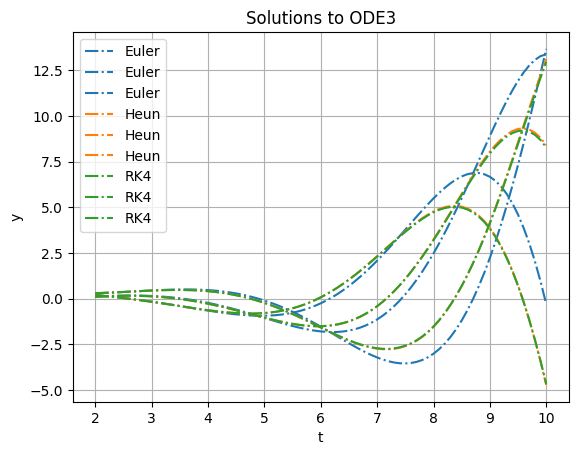

In [2]:
from solve_to import solve_to
from test_equations import ode3

# define the initial conditions
y0, t0, t1, delta_t = [0.3, 0.1, 0.2], 2, 10, 0.1

# solve the ODE
for i, method in enumerate(['Euler', 'Heun', 'RK4']):
    Y, t = solve_to(ode3, y0, t0, t1, delta_t, method)
    # plot the solution
    plt.plot(t, Y, label=method, color='C'+str(i), linestyle='-.')

plot_help(plt, 't', 'y', 'Solutions to ODE3', legend=True)

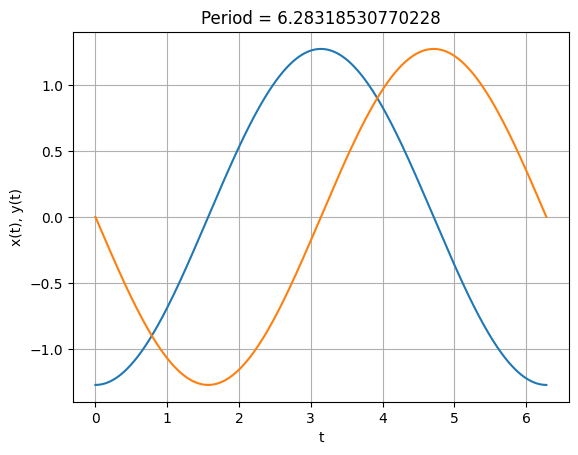

In [3]:
from shooting import Discretisation, shooting_solve
from test_equations import hopf

discret = Discretisation()

# initial guess
Y0, T, b = [0.1,0.1], 10, 1
u0 = np.append(Y0, T)

# solve the ode using the shooting method
fun = discret.shooting_setup(hopf, Y0, T=T, args=b)
Y0, T0 = shooting_solve(fun, u0)

# solve for one period of the solution
Y,t = solve_to(hopf, Y0, 0, T0, args=b)
plt.plot(t, Y)
plot_help(plt, 't', 'x(t), y(t)', 'Period = ' + str(T0))

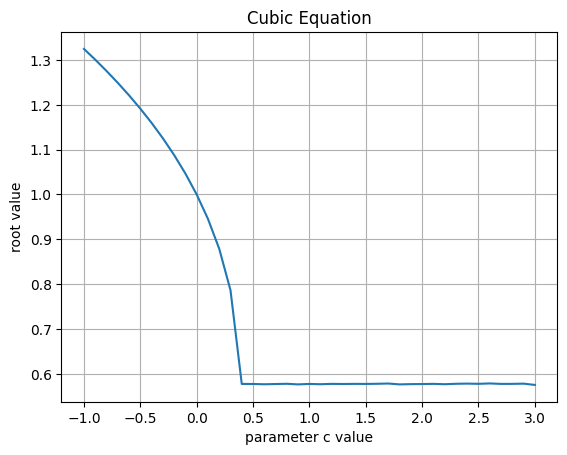

In [4]:
from continuation import Continuation
import scipy.optimize
from test_equations import cubic

# create continuation class
cont = Continuation(solver=scipy.optimize.root)
# create discretisation class
discret = Discretisation()
# initial guess
x0 , p0 = 1, -1
# solve for the root of the cubic equation using no discretisation
X, C = cont.nat_continuation(cubic, x0, p0, step=0.1, max_steps=40, discret=None)
# plot the solution
plt.figure()
plt.plot(C, X)
plot_help(plt, 'parameter c value', 'root value', 'Cubic Equation')




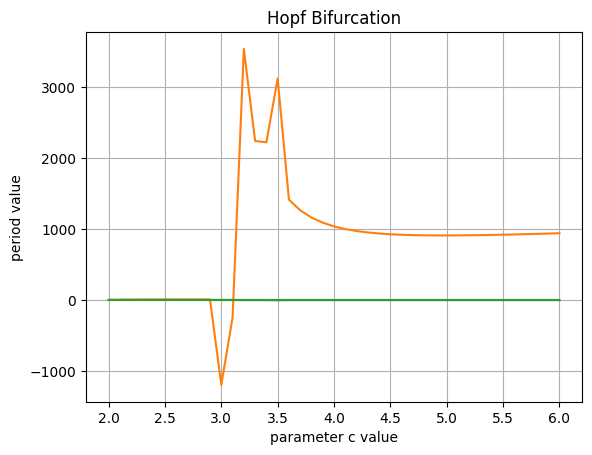

In [5]:
from test_equations import hopf_polar

# now need to test natural continuation with a differential equation - Hopf bifurcation and shooting discretisation
discret = Discretisation().shooting_setup

# initial guess
x0 , p0 = [1, 10,2], [2, 1]

# solve for the root of the hopf equation using shooting discretisation
X, C = cont.nat_continuation(hopf_polar, x0, p0, step=0.1, max_steps=40, discret=discret)

# plot the solution
plt.figure()
plt.plot(C, X)
plot_help(plt, 'parameter c value', 'period value', 'Hopf Bifurcation')


## PDE solvers 

Solver profiling and showing modularity
1. BVP solver
2. PDE solver
- Explicit methods
- Implicit methods

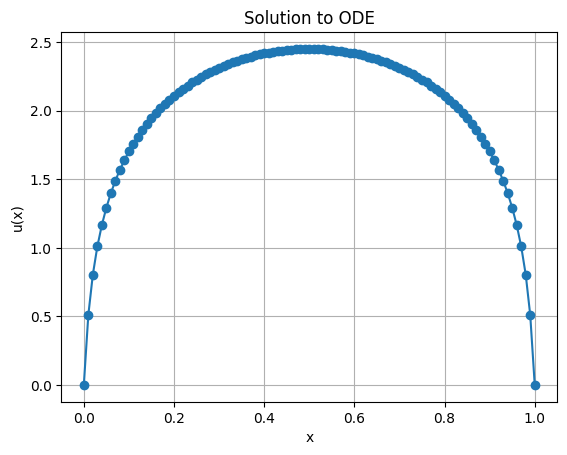

In [6]:
# define the BVP ODE to solve
m, c, k,  bound_type, alpha, beta, a, b, args = 1, 1, 1, 'DD', 0, 0, 0, 1, (3,)
q = lambda x, u, *args: np.exp(args[0] * u) # lambda function for q(x, u, args)

# create the ODE object
from bvp_solver import ODE
ODE = ODE(m, c, k, q, bound_type, alpha, beta, a, b, *args)

# create the solver object
from bvp_solver import Solver
N , method = 100, 'scipy'
solver = Solver(ODE, N, method)

# solve the ODE
u = solver.solve()
x = solver.x

# plot the solution
plt.plot(x, u, 'o-')
plot_help(plt, 'x', 'u(x)', 'Solution to ODE')


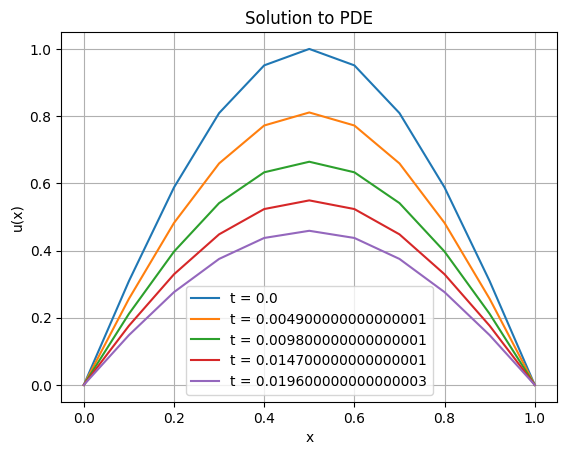

In [7]:
# demo of some of the PDE solvers - most complicated versions
from pde_solver import *

# make the PDE object
f, m, q, bound_type, alpha, beta, a, b, args = lambda x: np.sin((np.pi*(x-a)/b-a)), 1, 1, 'DD', 0, 0, 0, 1, (3,)
pde = PDE(f, m, q, bound_type, alpha, beta, a, b, *args)

# create the solver object
solver = Solver(pde, N=10, t_final=1, method='RK4')
u = solver.solve()

# plot the solution at 5 different times
plt.figure()
for i in range(5):
    plt.plot(solver.x, u[:,5*i], label='t = ' + str(solver.t[i]))
plot_help(plt, 'x', 'u(x)', 'Solution to PDE', legend=True)



In [26]:
# profiling of the solvers (for the equation in the previous cell)
stats, methods = profile(pde, N=50, t_final=1)

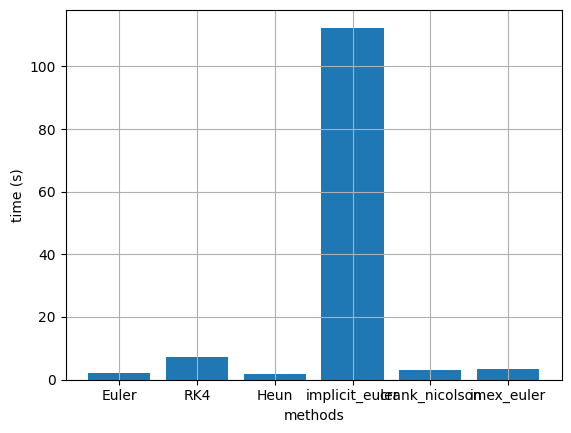

[{'<built-in method builtins.callable>': FunctionProfile(ncalls='40818', tottime=0.007, percall_tottime=0.0, cumtime=0.007, percall_cumtime=0.0, file_name='~', line_number=0), '<built-in method builtins.isinstance>': FunctionProfile(ncalls='40819', tottime=0.013, percall_tottime=0.0, cumtime=0.013, percall_cumtime=0.0, file_name='~', line_number=0), '<built-in method _operator.index>': FunctionProfile(ncalls='1', tottime=0.0, percall_tottime=0.0, cumtime=0.0, percall_cumtime=0.0, file_name='~', line_number=0), '<built-in method math.ceil>': FunctionProfile(ncalls='1', tottime=0.0, percall_tottime=0.0, cumtime=0.0, percall_cumtime=0.0, file_name='~', line_number=0), "<method 'disable' of '_lsprof.Profiler' objects>": FunctionProfile(ncalls='1', tottime=0.0, percall_tottime=0.0, cumtime=0.0, percall_cumtime=0.0, file_name='~', line_number=0), "<method 'astype' of 'numpy.ndarray' objects>": FunctionProfile(ncalls='1', tottime=0.0, percall_tottime=0.0, cumtime=0.0, percall_cumtime=0.0, fil

In [45]:
# for each stats object, extract the total time and plot as a bar chart
total_tt = []
num_calls = []
for i, method in enumerate(methods):

    stats[i].strip_dirs()
    total_tt.append(stats[i].get_stats_profile().total_tt)

plt.figure()
plt.bar(methods, total_tt)
plot_help(plt, 'methods', 'time (s)')


In [31]:
# why is implicit euler so slow?
print(stats[3].sort_stats('cumtime').print_stats())


         7082326 function calls (7082324 primitive calls) in 112.401 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002  112.398  112.398 pde_solver.py:113(solve)
        1    0.683    0.683  112.396  112.396 pde_solver.py:163(implicit_solve)
    20409    0.210    0.000  111.679    0.005 _root.py:24(root)
    20409    0.689    0.000  111.437    0.005 _minpack_py.py:184(_root_hybr)
    20409   34.691    0.002  107.506    0.005 {built-in method scipy.optimize._minpack._hybrd}
  2102243    8.251    0.000   75.048    0.000 pde_solver.py:191(F_solve)
  2102243   66.391    0.000   66.797    0.000 pde_solver.py:170(F)
    20409    0.172    0.000    3.016    0.000 _minpack_py.py:24(_check_func)
  2122652    0.413    0.000    0.413    0.000 {built-in method builtins.callable}
61236/61234    0.092    0.000    0.265    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    20409   


# A description of the key software design decisions made (40% of the marks)

A run through of the code

# A reflective learning log (30% of the marks)